<h1>LSTM forecast Model for Household Electricity Consumption</h1>

Long Short Term Memory (LSTM) is a recurrent neural network (RNN) architecture used in the field of deep learning. Unlike forward propagation neural networks, LSTM has feedback connections.

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

<h2>01: Load data</h2>

In [2]:
df = pd.read_csv('drive/MyDrive/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
 
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [20]:
df_resample = df.resample('h').sum() 
df_resample.shape

(34589, 7)

In [21]:

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.386208   0.177443   0.558893   0.382619        0.0   0.006820   
2   0.553644   0.103358   0.931236   0.549618        0.0   0.144652   
3   0.518286   0.110073   0.925886   0.510981        0.0   0.030869   
4   0.498217   0.096987   0.929217   0.490311        0.0   0.000000   
5   0.465887   0.099010   0.941472   0.459659        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.469451  0.553644  
2   0.782676  0.518286  
3   0.774169  0.498217  
4   0.778809  0.465887  
5   0.798917  0.335359  


In [22]:

# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


In [25]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt

<h2>02: Training data</h2>

Epoch 1/20
126/126 - 4s - loss: 0.0213 - val_loss: 0.0125 - 4s/epoch - 32ms/step
Epoch 2/20
126/126 - 2s - loss: 0.0129 - val_loss: 0.0111 - 2s/epoch - 13ms/step
Epoch 3/20
126/126 - 1s - loss: 0.0118 - val_loss: 0.0100 - 1s/epoch - 8ms/step
Epoch 4/20
126/126 - 2s - loss: 0.0109 - val_loss: 0.0093 - 2s/epoch - 13ms/step
Epoch 5/20
126/126 - 2s - loss: 0.0105 - val_loss: 0.0090 - 2s/epoch - 13ms/step
Epoch 6/20
126/126 - 2s - loss: 0.0103 - val_loss: 0.0089 - 2s/epoch - 15ms/step
Epoch 7/20
126/126 - 2s - loss: 0.0103 - val_loss: 0.0088 - 2s/epoch - 15ms/step
Epoch 8/20
126/126 - 1s - loss: 0.0102 - val_loss: 0.0088 - 1s/epoch - 9ms/step
Epoch 9/20
126/126 - 1s - loss: 0.0102 - val_loss: 0.0087 - 1s/epoch - 8ms/step
Epoch 10/20
126/126 - 1s - loss: 0.0102 - val_loss: 0.0088 - 1s/epoch - 12ms/step
Epoch 11/20
126/126 - 2s - loss: 0.0101 - val_loss: 0.0087 - 2s/epoch - 13ms/step
Epoch 12/20
126/126 - 2s - loss: 0.0101 - val_loss: 0.0087 - 2s/epoch - 14ms/step
Epoch 13/20
126/126 - 2s - l

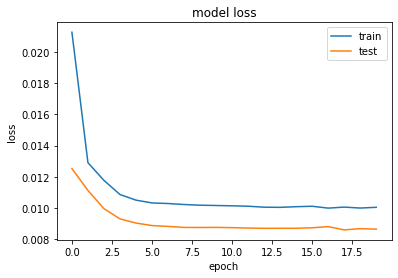

In [26]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [27]:
import numpy as np

<h2>03: Make a prediction</h2>

In [28]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

808/808 [==============================] - 3s 3ms/step


<h2>04: Poting prediction and actual data</h2>

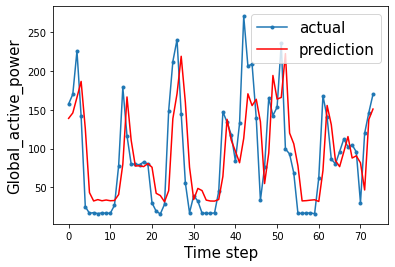

In [29]:
aa=[x for x in range(74)]
plt.plot(aa, inv_y[:74], marker='.', label="actual")
plt.plot(aa, inv_yhat[:74], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

<h2>05: Evaluat model

In [30]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [32]:
mae(inv_yhat,inv_y)

28.06623768739235

In [33]:
from sklearn.metrics import mean_squared_error,r2_score
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.585
